In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Redes Neurais - Trabalho 2

#### Chat-bot

Trained classes:
- apresentacao
- cardapio
- tempo_entrega
- horario_funcionamento
- fazer_pedido
- confirmar_pedido
- cancelar_pedido
- sim
- nao

Telegram bot: https://t.me/ufms_lab_pizzaria_chat_bot / @ufms_lab_pizzaria_chat_bot

Source code: https://github.com/ufms-lab/bert-chat-bot-telegram


## Configuration

### Libraries

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from transformers import AutoModelForMaskedLM
from transformers import AutoModelForCausalLM
from typing import Optional, Tuple
import pandas as pd
import numpy as np
import sklearn.model_selection as model_selection
from sklearn import preprocessing
from sklearn import metrics

from torch.utils.data import DataLoader
from torch.optim import AdamW

### Variables

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
patience_time = 5
loss_fct = nn.CrossEntropyLoss()

sheet_id = '1XNFDohlIBX8IRRcrVdha-_aLv27lzixZqmMFHaIkGpc'
sheet_name = 'general'
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

### Functions

In [ ]:
def plotLoss(model):
    plt.figure()
    plt.plot(model['loss_train'][1:])
    plt.plot(model['loss_eval'][1:])
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Loss Train', 'Loss Eval'])
    plt.show()

In [ ]:
def recoverTrainedModel(model):
    return torch.load(f'model_{model.name}.loss')

In [ ]:
def modelMetrics(model, dl_test):
    model.eval()
    ytrue = []
    ypred = []
    for batch,y in dl_test:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        predictions = torch.argmax(outputs, dim=-1)
        ytrue += y.tolist()
        ypred += predictions.cpu().tolist()
    return ytrue, ypred
    

In [ ]:
def trainModel(model, optimizer, dl_train, dl_eval):
    stop = False
    epoch = 0
    lowest_loss_eval = 10000
    last_best_result = 0
    loss_train = []
    loss_eval  = []
    while (not stop):
        model.train()
        lepochs = []
        for batch,y in dl_train:
            batch = {k: v.to(device) for k, v in batch.items()}
            y     = y.to(device)
            outputs = model(**batch)
            loss = loss_fct(outputs,y.type(torch.LongTensor).to(device))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            lepochs.append(loss.cpu().item())
        loss_train.append(np.mean(lepochs))
        model.eval()
        ytrue = []
        ypred = []
        for batch,y in dl_eval:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
                loss = loss_fct(outputs,y.type(torch.LongTensor).to(device))
                lepochs.append(loss.cpu().item())
            predictions = torch.argmax(outputs, dim=-1)
            ytrue += y.tolist()
            ypred += predictions.cpu().tolist()
        avg_loss_eval = np.mean(lepochs)
        loss_eval.append(avg_loss_eval)
        if avg_loss_eval < lowest_loss_eval:
            lowest_loss_eval = avg_loss_eval 
            last_best_result = 0
            print("Best model found!")
            actual_state = {
                'weights': model.state_dict(),
                'epoch': epoch,
                'loss_train': loss_train,
                'loss_eval': loss_eval
            }
            torch.save(actual_state,f'model_{model.name}.loss')
        last_best_result += 1
        if last_best_result > patience_time:
            stop = True
        print("epoch %d loss_train %4.3f loss_eval %4.3f last_best %d"%(epoch,loss_train[-1],loss_eval[-1],last_best_result))
        epoch += 1

### Dados para treinamento - Google sheets público

In [ ]:
df = pd.read_csv(url, delimiter=',')
rows = [list(row) for row in df.values]
rows.insert(0, df.columns.to_list())
df=pd.DataFrame(rows[1:],columns=rows[0])

In [ ]:
rows[0]

['apresentacao',
 'cardapio',
 'tempo_entrega',
 'horario_funcionamento',
 'fazer_pedido',
 'confirmar_pedido',
 'cancelar_pedido',
 'sim',
 'nao']

In [ ]:
intentions = rows[0]
xtrain_global = []
ytrain_global = []
for intension in intentions:
    lintension = df[intension].values.tolist()
    xtrain_global += lintension
    ytrain_global += [intension]*len(lintension)

### Definindo os conjuntos de TREINO, VALIDAÇÃO e TESTES

In [ ]:
xtemp, xtest, ytemp, ytest = model_selection.train_test_split(xtrain_global, ytrain_global, test_size=0.2, random_state=42, shuffle=True)
xtrain, xval, ytrain, yval = model_selection.train_test_split(xtemp, ytemp, test_size=0.4, random_state=42, shuffle=True)

### Dataset

In [ ]:
class GenericDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        label = torch.tensor(self.labels[idx])
        return (item,label)

    def __len__(self):
        return len(self.labels)

### Preprocessing

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(ytrain)

LabelEncoder()

### Model

In [ ]:
class GenericClassifier(nn.Module):
  def __init__(self,model,name,labels):
    super(GenericClassifier,self).__init__()
    self.name = name
    self.base_model = model.base_model
    self.config = model.config
    self.labels = labels
    self.cls = nn.Linear(self.config.hidden_size, len(labels))

  def forward(
    self,
    input_ids: Optional[torch.Tensor] = None,
    attention_mask: Optional[torch.Tensor] = None,
    token_type_ids: Optional[torch.Tensor] = None,
    ) ->Tuple[torch.Tensor]:

    outputs = self.base_model(
      input_ids,
      attention_mask=attention_mask,
      #token_type_ids=token_type_ids,
    )
    sequence_output = outputs[0][:,0,:]
    prediction = self.cls(sequence_output)
    return prediction

## Model - neuralmind/bert-base-portuguese-cased

### Configuration

In [ ]:
model_pretrained = AutoModelForMaskedLM.from_pretrained('neuralmind/bert-base-portuguese-cased')
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)

train_encodings = tokenizer(xtrain, truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(xval, truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(xtest, truncation=True, padding=True, return_tensors='pt')

ds_train = GenericDataset(train_encodings,le.transform(ytrain))
ds_val   = GenericDataset(val_encodings,le.transform(yval))
ds_test   = GenericDataset(test_encodings,le.transform(ytest))

dl_train = DataLoader(ds_train,shuffle=True,batch_size=8)
dl_eval  = DataLoader(ds_val,batch_size=8)
dl_test  = DataLoader(ds_test,batch_size=8)

model = GenericClassifier(model=model_pretrained,name="bert",labels=intentions).to(device)

optimizer = AdamW(model.parameters(), lr=5e-5, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


### Train

In [ ]:
trainModel(model, optimizer, dl_train, dl_eval)

<ipython-input-86-4125cd2d00c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Best model found!
epoch 0 loss_train 1.333 loss_eval 1.067 last_best 1
Best model found!
epoch 1 loss_train 0.424 loss_eval 0.423 last_best 1
Best model found!
epoch 2 loss_train 0.170 loss_eval 0.233 last_best 1
Best model found!
epoch 3 loss_train 0.060 loss_eval 0.202 last_best 1
Best model found!
epoch 4 loss_train 0.064 loss_eval 0.189 last_best 1
Best model found!
epoch 5 loss_train 0.025 loss_eval 0.185 last_best 1
epoch 6 loss_train 0.035 loss_eval 0.218 last_best 2
epoch 7 loss_train 0.077 loss_eval 0.231 last_best 3
epoch 8 loss_train 0.049 loss_eval 0.248 last_best 4
epoch 9 loss_train 0.088 loss_eval 0.237 last_best 5
epoch 10 loss_train 0.030 loss_eval 0.208 last_best 6


### Recover (from disk) / Metrics

In [ ]:
recover = recoverTrainedModel(model)
ytrue, lres = modelMetrics(model, dl_test)

<ipython-input-86-4125cd2d00c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


### LOSS Train / Eval

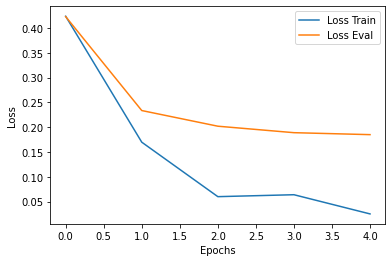

In [ ]:
plotLoss(recover)

### Confusion Matrix

In [ ]:
print(metrics.confusion_matrix(ytrue, lres))

[[23  0  0  0  0  1  0  1  0]
 [ 0 15  0  0  0  0  0  0  1]
 [ 0  0 13  0  0  0  0  0  0]
 [ 1  0  0 17  0  0  2  3  0]
 [ 0  0  0  0 22  0  0  0  0]
 [ 0  0  0  0  0 22  0  0  0]
 [ 0  0  0  0  0  0 17  2  0]
 [ 2  0  0  0  0  0  1 15  0]
 [ 0  0  0  0  0  0  0  0 22]]


### Classification

In [ ]:
print(metrics.classification_report(ytrue, lres, target_names=intentions))

                       precision    recall  f1-score   support

         apresentacao       0.88      0.92      0.90        25
             cardapio       1.00      0.94      0.97        16
        tempo_entrega       1.00      1.00      1.00        13
horario_funcionamento       1.00      0.74      0.85        23
         fazer_pedido       1.00      1.00      1.00        22
     confirmar_pedido       0.96      1.00      0.98        22
      cancelar_pedido       0.85      0.89      0.87        19
                  sim       0.71      0.83      0.77        18
                  nao       0.96      1.00      0.98        22

             accuracy                           0.92       180
            macro avg       0.93      0.92      0.92       180
         weighted avg       0.93      0.92      0.92       180



### Simple test

In [ ]:
token=tokenizer("voce tem uma lista com os sabores das pizzas?", return_tensors='pt').to(device)
pred=model(**token)
le.inverse_transform(pred.argmax(dim=-1).cpu())[0]

'cardapio'

## Model - distilbert-base-multilingual-cased

### Configuration

In [ ]:
model_pretrained = AutoModelForMaskedLM.from_pretrained('distilbert-base-multilingual-cased')
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased', do_lower_case=False)

train_encodings = tokenizer(xtrain, truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(xval, truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(xtest, truncation=True, padding=True, return_tensors='pt')

ds_train = GenericDataset(train_encodings,le.transform(ytrain))
ds_val   = GenericDataset(val_encodings,le.transform(yval))
ds_test   = GenericDataset(test_encodings,le.transform(ytest))

dl_train = DataLoader(ds_train,shuffle=True,batch_size=8)
dl_eval  = DataLoader(ds_val,batch_size=8)
dl_test  = DataLoader(ds_test,batch_size=8)

model = GenericClassifier(model=model_pretrained,name="distilbert",labels=intentions).to(device)

optimizer = AdamW(model.parameters(), lr=5e-5, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2)

### Train

In [ ]:
trainModel(model, optimizer, dl_train, dl_eval)

<ipython-input-86-4125cd2d00c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Best model found!
epoch 0 loss_train 1.669 loss_eval 1.334 last_best 1
Best model found!
epoch 1 loss_train 0.521 loss_eval 0.521 last_best 1
Best model found!
epoch 2 loss_train 0.171 loss_eval 0.282 last_best 1
Best model found!
epoch 3 loss_train 0.074 loss_eval 0.226 last_best 1
Best model found!
epoch 4 loss_train 0.069 loss_eval 0.223 last_best 1
Best model found!
epoch 5 loss_train 0.040 loss_eval 0.216 last_best 1
epoch 6 loss_train 0.022 loss_eval 0.223 last_best 2
Best model found!
epoch 7 loss_train 0.030 loss_eval 0.213 last_best 1
epoch 8 loss_train 0.035 loss_eval 0.217 last_best 2
epoch 9 loss_train 0.029 loss_eval 0.236 last_best 3
Best model found!
epoch 10 loss_train 0.011 loss_eval 0.186 last_best 1
epoch 11 loss_train 0.028 loss_eval 0.244 last_best 2
epoch 12 loss_train 0.017 loss_eval 0.210 last_best 3
epoch 13 loss_train 0.008 loss_eval 0.200 last_best 4
epoch 14 loss_train 0.008 loss_eval 0.197 last_best 5
epoch 15 loss_train 0.006 loss_eval 0.200 last_best 6


### Recover (from disk) / Metrics

In [ ]:
recover = recoverTrainedModel(model)
ytrue, lres = modelMetrics(model, dl_test)

<ipython-input-86-4125cd2d00c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


### LOSS Train / Eval

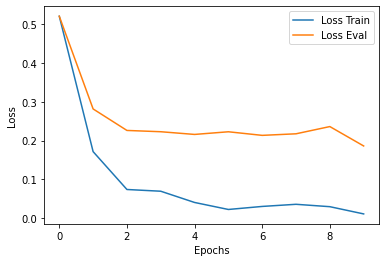

In [ ]:
plotLoss(recover)

### Confusion Matrix

In [ ]:
print(metrics.confusion_matrix(ytrue, lres))

[[16  0  0  0  0  3  1  5  0]
 [ 0 14  0  0  0  1  0  1  0]
 [ 0  0 13  0  0  0  0  0  0]
 [ 1  0  0 16  1  0  1  3  1]
 [ 0  0  0  1 21  0  0  0  0]
 [ 0  0  0  0  0 22  0  0  0]
 [ 0  0  0  0  0  0 18  1  0]
 [ 6  0  0  0  0  0  0 12  0]
 [ 1  0  0  0  0  0  0  0 21]]


### Classification

In [ ]:
print(metrics.classification_report(ytrue, lres, target_names=intentions))

                       precision    recall  f1-score   support

         apresentacao       0.67      0.64      0.65        25
             cardapio       1.00      0.88      0.93        16
        tempo_entrega       1.00      1.00      1.00        13
horario_funcionamento       0.94      0.70      0.80        23
         fazer_pedido       0.95      0.95      0.95        22
     confirmar_pedido       0.85      1.00      0.92        22
      cancelar_pedido       0.90      0.95      0.92        19
                  sim       0.55      0.67      0.60        18
                  nao       0.95      0.95      0.95        22

             accuracy                           0.85       180
            macro avg       0.87      0.86      0.86       180
         weighted avg       0.86      0.85      0.85       180



### Simple test

In [ ]:
token=tokenizer("voce tem uma lista com os sabores das pizzas?", return_tensors='pt').to(device)
pred=model(**token)
le.inverse_transform(pred.argmax(dim=-1).cpu())[0]

'cardapio'

## Model - Twitter/twhin-bert-large

### Configuration

In [ ]:
model_pretrained = AutoModelForMaskedLM.from_pretrained('Twitter/twhin-bert-base')
tokenizer = AutoTokenizer.from_pretrained('Twitter/twhin-bert-base')

train_encodings = tokenizer(xtrain, truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(xval, truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(xtest, truncation=True, padding=True, return_tensors='pt')

ds_train = GenericDataset(train_encodings,le.transform(ytrain))
ds_val   = GenericDataset(val_encodings,le.transform(yval))
ds_test   = GenericDataset(test_encodings,le.transform(ytest))

dl_train = DataLoader(ds_train,shuffle=True,batch_size=8)
dl_eval  = DataLoader(ds_val,batch_size=8)
dl_test  = DataLoader(ds_test,batch_size=8)

model = GenericClassifier(model=model_pretrained,name="twhin",labels=intentions).to(device)

optimizer = AdamW(model.parameters(), lr=5e-5, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


### Train

In [ ]:
trainModel(model, optimizer, dl_train, dl_eval)

<ipython-input-86-4125cd2d00c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Best model found!
epoch 0 loss_train 1.775 loss_eval 1.466 last_best 1
Best model found!
epoch 1 loss_train 0.736 loss_eval 0.639 last_best 1
Best model found!
epoch 2 loss_train 0.285 loss_eval 0.363 last_best 1
Best model found!
epoch 3 loss_train 0.173 loss_eval 0.295 last_best 1
Best model found!
epoch 4 loss_train 0.110 loss_eval 0.250 last_best 1
epoch 5 loss_train 0.105 loss_eval 0.285 last_best 2
epoch 6 loss_train 0.112 loss_eval 0.266 last_best 3
Best model found!
epoch 7 loss_train 0.032 loss_eval 0.232 last_best 1
epoch 8 loss_train 0.047 loss_eval 0.243 last_best 2
Best model found!
epoch 9 loss_train 0.017 loss_eval 0.210 last_best 1
epoch 10 loss_train 0.015 loss_eval 0.219 last_best 2
epoch 11 loss_train 0.017 loss_eval 0.329 last_best 3
Best model found!
epoch 12 loss_train 0.045 loss_eval 0.205 last_best 1
epoch 13 loss_train 0.106 loss_eval 0.263 last_best 2
epoch 14 loss_train 0.072 loss_eval 0.236 last_best 3
epoch 15 loss_train 0.031 loss_eval 0.229 last_best 4
ep

### Recover (from disk) / Metrics

In [ ]:
recover = recoverTrainedModel(model)
ytrue, lres = modelMetrics(model, dl_test)

<ipython-input-86-4125cd2d00c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


### LOSS Train / Eval

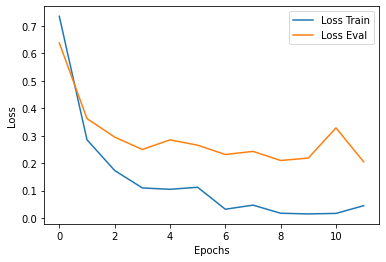

In [ ]:
plotLoss(recover)

### Confusion Matrix

In [ ]:
print(metrics.confusion_matrix(ytrue, lres))

[[22  0  1  0  1  0  0  1  0]
 [ 0 15  0  1  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0]
 [ 0  0  0 18  1  0  2  2  0]
 [ 0  0  0  1 21  0  0  0  0]
 [ 0  0  0  1  0 21  0  0  0]
 [ 2  0  0  0  0  0 16  1  0]
 [ 7  0  0  0  0  0  0 11  0]
 [ 0  0  0  1  0  0  0  1 20]]


### Classification

In [ ]:
print(metrics.classification_report(ytrue, lres, target_names=intentions))

                       precision    recall  f1-score   support

         apresentacao       0.71      0.88      0.79        25
             cardapio       1.00      0.94      0.97        16
        tempo_entrega       0.93      1.00      0.96        13
horario_funcionamento       0.82      0.78      0.80        23
         fazer_pedido       0.91      0.95      0.93        22
     confirmar_pedido       1.00      0.95      0.98        22
      cancelar_pedido       0.89      0.84      0.86        19
                  sim       0.69      0.61      0.65        18
                  nao       1.00      0.91      0.95        22

             accuracy                           0.87       180
            macro avg       0.88      0.87      0.88       180
         weighted avg       0.88      0.87      0.87       180



### Simple test

In [ ]:
token=tokenizer("voce tem uma lista com os sabores das pizzas?", return_tensors='pt').to(device)
pred=model(**token)
le.inverse_transform(pred.argmax(dim=-1).cpu())[0]

'cardapio'

## Model - pierreguillou/gpt2-small-portuguese

### Configuration

In [ ]:
model_pretrained = AutoModelForCausalLM.from_pretrained("pierreguillou/gpt2-small-portuguese")
tokenizer = AutoTokenizer.from_pretrained("pierreguillou/gpt2-small-portuguese")

train_encodings = tokenizer(xtrain, truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(xval, truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(xtest, truncation=True, padding=True, return_tensors='pt')

ds_train = GenericDataset(train_encodings,le.transform(ytrain))
ds_val   = GenericDataset(val_encodings,le.transform(yval))
ds_test   = GenericDataset(test_encodings,le.transform(ytest))

dl_train = DataLoader(ds_train,shuffle=True,batch_size=8)
dl_eval  = DataLoader(ds_val,batch_size=8)
dl_test  = DataLoader(ds_test,batch_size=8)

model = GenericClassifier(model=model_pretrained,name="gpt2",labels=intentions).to(device)

optimizer = AdamW(model.parameters(), lr=5e-5, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-2)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


### Train

In [ ]:
trainModel(model, optimizer, dl_train, dl_eval)

<ipython-input-86-4125cd2d00c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Best model found!
epoch 0 loss_train 2.242 loss_eval 2.229 last_best 1
Best model found!
epoch 1 loss_train 2.195 loss_eval 2.188 last_best 1
Best model found!
epoch 2 loss_train 2.141 loss_eval 2.111 last_best 1
Best model found!
epoch 3 loss_train 1.943 loss_eval 1.932 last_best 1
Best model found!
epoch 4 loss_train 1.667 loss_eval 1.692 last_best 1
Best model found!
epoch 5 loss_train 1.547 loss_eval 1.602 last_best 1
Best model found!
epoch 6 loss_train 1.383 loss_eval 1.471 last_best 1
epoch 7 loss_train 1.385 loss_eval 1.587 last_best 2
Best model found!
epoch 8 loss_train 1.300 loss_eval 1.440 last_best 1
Best model found!
epoch 9 loss_train 1.100 loss_eval 1.296 last_best 1
Best model found!
epoch 10 loss_train 0.949 loss_eval 1.275 last_best 1
Best model found!
epoch 11 loss_train 0.931 loss_eval 1.262 last_best 1
epoch 12 loss_train 0.912 loss_eval 1.266 last_best 2
Best model found!
epoch 13 loss_train 0.911 loss_eval 1.232 last_best 1
Best model found!
epoch 14 loss_train 

### Recover (from disk) / Metrics

In [ ]:
recover = recoverTrainedModel(model)
ytrue, lres = modelMetrics(model, dl_test)

<ipython-input-86-4125cd2d00c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


### LOSS Train / Eval

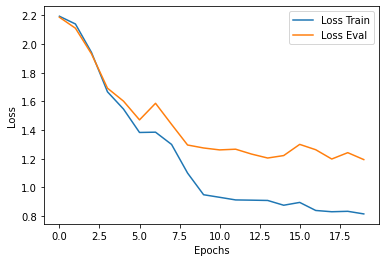

In [ ]:
plotLoss(recover)

### Confusion Matrix

In [ ]:
print(metrics.confusion_matrix(ytrue, lres))

[[19  0  0  0  0  2  1  1  2]
 [ 2  9  1  0  3  1  0  0  0]
 [ 0  0  5  0  5  3  0  0  0]
 [ 2  0  3  7  1  0  3  5  2]
 [ 0  0  2  0 16  1  1  1  1]
 [ 0  0  0  2  0 18  0  0  2]
 [ 0  0  0  1  1  3 12  1  1]
 [ 2  0  0  2  2  1  0  7  4]
 [ 2  1  1  0  2  4  0  2 10]]


### Classification

In [ ]:
print(metrics.classification_report(ytrue, lres, target_names=intentions))

                       precision    recall  f1-score   support

         apresentacao       0.70      0.76      0.73        25
             cardapio       0.90      0.56      0.69        16
        tempo_entrega       0.42      0.38      0.40        13
horario_funcionamento       0.58      0.30      0.40        23
         fazer_pedido       0.53      0.73      0.62        22
     confirmar_pedido       0.55      0.82      0.65        22
      cancelar_pedido       0.71      0.63      0.67        19
                  sim       0.41      0.39      0.40        18
                  nao       0.45      0.45      0.45        22

             accuracy                           0.57       180
            macro avg       0.58      0.56      0.56       180
         weighted avg       0.59      0.57      0.56       180



### Simple test

In [ ]:
token=tokenizer("voce tem uma lista com os sabores das pizzas?", return_tensors='pt').to(device)
pred=model(**token)
le.inverse_transform(pred.argmax(dim=-1).cpu())[0]

'horario_funcionamento'

# Final step - Model neuralmind/bert-base-portuguese-cased full

After testing several inputs, this was the best value I got

lr=1e-4, betas=(0.9, 0.99), eps=1e-2, weight_decay=0.05

### Dataset with only 10% of entries for validation

In [ ]:
xtrain, xval, ytrain, yval = model_selection.train_test_split(xtrain_global, ytrain_global, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
model_pretrained = AutoModelForMaskedLM.from_pretrained('neuralmind/bert-base-portuguese-cased')
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)

tokenizer.model_max_length=1024

train_encodings = tokenizer(xtrain, truncation=True, padding=True, return_tensors='pt')
val_encodings = tokenizer(xval, truncation=True, padding=True, return_tensors='pt')

ds_train = GenericDataset(train_encodings,le.transform(ytrain))
ds_val   = GenericDataset(val_encodings,le.transform(yval))

dl_train = DataLoader(ds_train,shuffle=True,batch_size=8)
dl_eval  = DataLoader(ds_val,batch_size=8)

model = GenericClassifier(model=model_pretrained,name="bert-base-portuguese-cased",labels=intentions).to(device)

optimizer = AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.99), eps=1e-2, weight_decay=0.05)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trainModel(model, optimizer, dl_train, dl_eval)

<ipython-input-86-4125cd2d00c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Best model found!
epoch 0 loss_train 1.604 loss_eval 1.526 last_best 1
Best model found!
epoch 1 loss_train 0.616 loss_eval 0.590 last_best 1
Best model found!
epoch 2 loss_train 0.303 loss_eval 0.301 last_best 1
Best model found!
epoch 3 loss_train 0.151 loss_eval 0.166 last_best 1
Best model found!
epoch 4 loss_train 0.105 loss_eval 0.119 last_best 1
Best model found!
epoch 5 loss_train 0.065 loss_eval 0.082 last_best 1
Best model found!
epoch 6 loss_train 0.050 loss_eval 0.079 last_best 1
epoch 7 loss_train 0.053 loss_eval 0.083 last_best 2
Best model found!
epoch 8 loss_train 0.034 loss_eval 0.064 last_best 1
Best model found!
epoch 9 loss_train 0.026 loss_eval 0.057 last_best 1
Best model found!
epoch 10 loss_train 0.029 loss_eval 0.055 last_best 1
Best model found!
epoch 11 loss_train 0.029 loss_eval 0.053 last_best 1
Best model found!
epoch 12 loss_train 0.020 loss_eval 0.053 last_best 1
Best model found!
epoch 13 loss_train 0.020 loss_eval 0.052 last_best 1
epoch 14 loss_train 

In [ ]:
recover = recoverTrainedModel(model)
ytrue, lres = modelMetrics(model, dl_eval)

<ipython-input-86-4125cd2d00c9>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


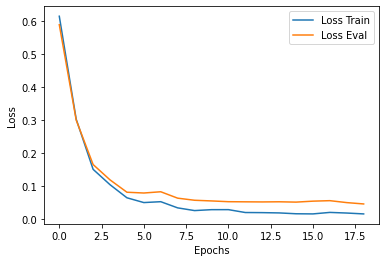

In [ ]:
plotLoss(recover)

In [ ]:
print(metrics.confusion_matrix(ytrue, lres))

[[ 8  0  0  0  0  0  1  2  0]
 [ 0  9  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  2  0  0]
 [ 0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  1  6  0]
 [ 0  0  0  0  0  0  0  0 13]]


In [ ]:
print(metrics.classification_report(ytrue, lres, target_names=intentions))

                       precision    recall  f1-score   support

         apresentacao       1.00      0.73      0.84        11
             cardapio       1.00      1.00      1.00         9
        tempo_entrega       1.00      1.00      1.00         8
horario_funcionamento       1.00      0.87      0.93        15
         fazer_pedido       1.00      1.00      1.00         9
     confirmar_pedido       1.00      1.00      1.00        11
      cancelar_pedido       0.64      1.00      0.78         7
                  sim       0.75      0.86      0.80         7
                  nao       1.00      1.00      1.00        13

             accuracy                           0.93        90
            macro avg       0.93      0.94      0.93        90
         weighted avg       0.95      0.93      0.94        90



In [ ]:
model_checkpoint = {
    'model': model.state_dict(),
    'config': model.config,
    'intentions': intentions,
    'tokenizer': tokenizer
}

torch.save(model_checkpoint, 'bert-base-portuguese-cased.pth')

### The chat-bot is using this last trained model, check out the source code on [github](https://github.com/ufms-lab/bert-chat-bot-telegram) ;)

#### The following is the implementation that was used in the Chat-bot in AWS Lambda

In [ ]:
from transformers import BertForMaskedLM

class ChatbotClassifier:
  def __init__(self) -> None:
    self.device = torch.device("cpu")
    self.prediction = ['apresentacao', 'cancelar_pedido', 'cardapio', 'confirmar_pedido',
      'fazer_pedido', 'horario_funcionamento', 'nao', 'sim',
      'tempo_entrega'] # Here I don't use sklearn, I was having a lot of conflict with the embedded environment in AWS Lambda

    # Here is a difference, in AWS Lambda I get the model from S3
    model_checkpoint = torch.load("bert-base-portuguese-cased.pth", map_location=self.device)

    self.intentions = model_checkpoint['intentions']
    self.tokenizer = model_checkpoint['tokenizer']

    model_pretrained = BertForMaskedLM(model_checkpoint['config'])

    self.model = GenericClassifier(model=model_pretrained ,name="bert-base-portuguese-cased",labels=self.intentions).to(self.device)
    self.model.load_state_dict(model_checkpoint['model'])
    self.model.eval()

  def __call__(self, telegram_message: str) -> str:
    token = self.tokenizer(telegram_message, return_tensors='pt').to(self.device)
    pred = self.model(**token)
    response = self.prediction[pred.argmax(dim=-1).cpu()[0]]

    return response

classificador = ChatbotClassifier()

In [ ]:
classificador("vcs tem cardapio?")

'cardapio'

In [ ]:
classificador("olá, tudo bem?")

'apresentacao'

In [ ]:
classificador("não quero mais o pedido")

'cancelar_pedido'